# Walk2D

This example demonstrates global adversarial stress testing and policy analysis in a 2D random walk environment.
- **System under test:** inactive; does nothing to control pawn movement or avoid failure.
- **Failure criterion:** pawn enters circular failure region.
- **Stochastic disturbance:** 2-dimensional pawn movement, normally distributed and uncorrelated.

In this case, the AST problem reduces to a simple goal-seeking reinforcement learning problem. This allows us to easily evaluate the efficacy of the solver and policy analysis.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.develop(path="../..")
Pkg.instantiate()

  Activating environment at `C:\Users\rlipkis\.julia\dev\adastress\examples\walk2d\Project.toml`
Path `../..` exists and looks like the correct package. Using existing path.
   Resolving package versions...
  No Changes to `C:\Users\rlipkis\.julia\dev\adastress\examples\walk2d\Project.toml`
  No Changes to `C:\Users\rlipkis\.julia\dev\adastress\examples\walk2d\Manifest.toml`


In [2]:
using Revise

In [3]:
using AdaStress
import AdaStress.GrayBox
using Distributions
using Random
using Plots

## Pawn

In [4]:
Base.@kwdef mutable struct Initialization
    x::Distribution = Uniform(0, 10)
    y::Distribution = Uniform(0, 10)
end

Base.@kwdef mutable struct Pawn
    x::Float64 = 0.0
    y::Float64 = 0.0
end

vec(pawn::Pawn) = [pawn.x, pawn.y]

observation(pawn::Pawn) = vec(pawn) / 10.0 # normalized state

function initialize(pawn::Pawn, init::Initialization)
    pawn.x = rand(init.x)
    pawn.y = rand(init.y)
end

function update(pawn::Pawn, Δx::Float64, Δy::Float64)
    pawn.x += Δx
    pawn.y += Δy
end

update (generic function with 1 method)

## Disturbance and failure models

In [5]:
Base.@kwdef mutable struct Disturbance
	x::Distribution = Normal(0.0, 0.25)
	y::Distribution = Normal(0.0, 0.25)
end

Base.@kwdef mutable struct FailureZone
	x::Float64 = 0.0
	y::Float64 = 0.0
	r::Float64 = 0.0
end

Base.in(pawn::Pawn, zone::FailureZone) = (pawn.x - zone.x)^2 + (pawn.y - zone.y)^2 <= zone.r^2

distance(pawn::Pawn, zone::FailureZone) = max(sqrt((pawn.x - zone.x)^2 + (pawn.y - zone.y)^2) - zone.r, 0.0)

distance (generic function with 1 method)

## Metrics

In [6]:
Base.@kwdef mutable struct Metrics
    d::Float64 = 0.0
	in_zone::Bool = false
end

const Log = Dict{String, Any}

function initialize(m::Metrics, pawn::Pawn, zone::FailureZone)
	update(m, pawn, zone)
end

function update(m::Metrics, pawn::Pawn, zone::FailureZone)
    m.d = distance(pawn, zone) 
	m.in_zone = pawn in zone
end

update (generic function with 2 methods)

## Simulator

In [7]:
Base.@kwdef mutable struct Simulator <: AdaStress.GrayBox
	t::Float64 = 0.0
	t_max::Float64 = 50.0
	pawn::Pawn = Pawn()
	init::Initialization = Initialization()
	disturbance::Disturbance = Disturbance()
	zone::FailureZone = FailureZone(7, 3, 1)
	metrics::Metrics = Metrics()
    env::AdaStress.Environment = AdaStress.Environment()
    log::Log = Log()
    logging::Bool = false
    rand_time::Bool = true
end

function initialize(sim::Simulator)
	sim.t = sim.rand_time ? rand() * sim.t_max : 0.0
	initialize(sim.pawn, sim.init)
	initialize(sim.metrics, sim.pawn, sim.zone)
    sim.env[:Δx] = sim.disturbance.x
    sim.env[:Δy] = sim.disturbance.y
    initialize(sim.log, sim)
    return
end

function update(sim::Simulator, value::AdaStress.EnvironmentValue)
	sim.t += 1.0
	update(sim.pawn, value[:Δx], value[:Δy])
	update(sim.metrics, sim.pawn, sim.zone)
	update(sim.log, sim)
	return
end

update (generic function with 3 methods)

## Logging

In [8]:
function initialize(log::Log, sim::Simulator)
    sim.logging || return
    log["t"] = [sim.t]
    log["pawn"] = [vec(sim.pawn)]
    log["d"] = [sim.metrics.d]
    log["in_zone"] = [sim.metrics.in_zone]
end

function update(log::Log, sim::Simulator)
    sim.logging || return
    push!(log["t"], sim.t)
    push!(log["pawn"], vec(sim.pawn))
    push!(log["d"], sim.metrics.d)
    push!(log["in_zone"], sim.metrics.in_zone)
end

update (generic function with 4 methods)

## Interface setup

In [9]:
Interface.reset!(sim::Simulator) = initialize(sim)

Interface.environment(sim::Simulator) = sim.env

Interface.observe(sim::Simulator) = vcat(observation(sim.pawn), sim.t / sim.t_max)

Interface.step!(sim::Simulator, x::AdaStress.EnvironmentValue) = update(sim, x)

Interface.isterminal(sim::Simulator) = sim.t >= sim.t_max

Interface.isevent(sim::Simulator) = sim.metrics.in_zone

Interface.distance(sim::Simulator) = sim.metrics.d

## Solver

In [10]:
AdaStress.clean()
AdaStress.enable("SoftActorCritic")
using AdaStress.SoftActorCritic

┌ Info: Cleaned submodule environment.
└ @ AdaStress C:\Users\rlipkis\.julia\dev\adastress\src\utils.jl:175
┌ Info: Enabled submodule SoftActorCritic.
└ @ AdaStress C:\Users\rlipkis\.julia\dev\adastress\src\utils.jl:93


In [11]:
function mdp_env(; kwargs...)
    mdp = Interface.ASTMDP(Simulator(; kwargs...))
    mdp.reward.event_bonus = 100.0
    return mdp
end

mdp_env (generic function with 1 method)

In [12]:
Random.seed!(0)
sac = SAC(;
    obs_dim=3, 
    act_dim=2,
    gamma=0.999,
    act_mins=-3.0*ones(2),
    act_maxs=3.0*ones(2),
    hidden_sizes=[30,30,30],
    num_q=3,
    max_buffer_size=1000000,
    linearized=true,
    batch_size=128,
    epochs=50, # low value for testing only; set to >25 to see learning
    steps_per_epoch=1000,
    start_steps=10000,
    max_ep_len=50,
    update_after=10000,
    update_every=1000,
    num_test_episodes=100,
    displays=[(:fails, mdp -> mdp.sim.metrics.in_zone)]
)

SoftActorCritic.ProgressMeter.ijulia_behavior(:clear)
ac, info = sac(mdp_env)

Progress: 100%|█████████████████████████████████████████| Time: 0:04:45
  epoch:  50
  score:  15.494899
  stdev:  0.8275877
  fails:  0.23


(MLPActorCritic(SoftActorCritic.SquashedGaussianMLPActor(Chain(Dense(3, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu)), Dense(30, 2), Dense(30, 2), Float32[-3.0, -3.0], Float32[3.0, 3.0], Random._GLOBAL_RNG(), nothing, true), SoftActorCritic.MLPQFunction[SoftActorCritic.MLPQFunction(Chain(Dense(5, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu), Dense(30, 1))), SoftActorCritic.MLPQFunction(Chain(Dense(5, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu), Dense(30, 1))), SoftActorCritic.MLPQFunction(Chain(Dense(5, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu), Dense(30, 1)))]), Dict{String, Any}("score" => Any[3.639376f0, 5.2687273f0, 9.613567f0, 7.585521f0, 8.496718f0, 15.963749f0, 14.148372f0, 30.579405f0, 16.41091f0, 23.505365f0  …  17.623241f0, 16.812794f0, 18.550406f0, 21.802977f0, 18.454039f0, 23.834307f0, 17.070839f0, 15.411732f0, 20.482841f0, 15.494899f0], "stdev" => Any[0.11967947f0, 0.11784779f0, 0.14081514f0, 0.16352239f0, 0.18171981f0, 0.24147297f0, 0.30741

In [13]:
# ac.pi.rng_gpu = nothing
# AdaStress.Interface.BSON.@save joinpath(pwd(), "ac.bson") ac 

## Value function

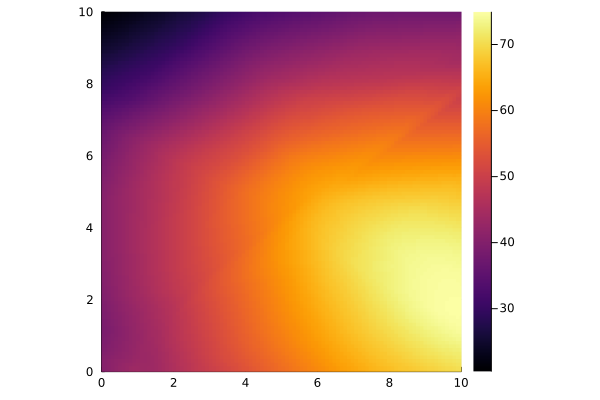

In [14]:
xs = Float32.(collect(range(0, 10; length=100)))
ys = Float32.(collect(range(0, 10; length=100)))

function get_policy(x, y; τ=0.0)
    o = Float32.(vcat(x / 10, y / 10, τ))
    a = ac(o)
    O = reshape(o, :, 1)
    A = reshape(a, :, 1)
    mean(q(O, A)[] for q in ac.qs)
end

qs = get_policy.(xs, ys')'
p = heatmap(xs, ys, qs; aspect_ratio=:equal, xlims=(0, 10), ylims=(0, 10))

## Sample trajectories

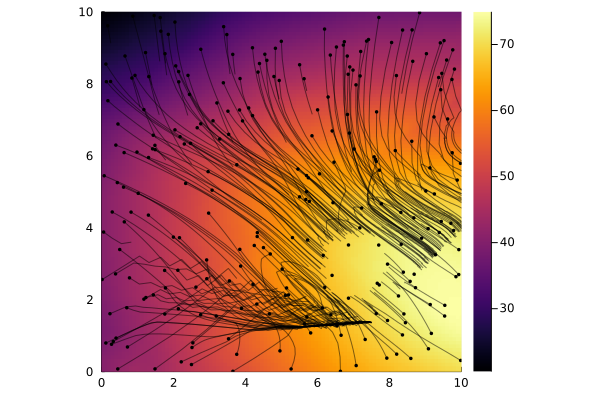

In [15]:
mdp = mdp_env()
mdp.sim.logging = true
n_runs = 250

for _ in 1:n_runs
    Interface.reset!(mdp)
    while !Interface.terminated(mdp)
        a = ac(Interface.observe(mdp))
        Interface.act!(mdp, a)
    end
    hist = mdp.sim.log["pawn"]
    scatter!(p, [hist[1][1]], [hist[1][2]],; mc=:black, ms=2, label=:none)
    plot!(p, getindex.(hist, 1), getindex.(hist, 2); lc=:black, alpha=0.5, label=:none)
end
p